In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

In [20]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

# Purpose
- Purpose of this notebook is to train a calibrated probablistic classification model using LightGBM

In [2]:
import warnings
import gc
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve, CalibrationDisplay

from src.pipeline_transformers import ColumnDropperTransformer

# Load Data

In [3]:
nrows = None

X_train = pd.read_csv("data/transformed/X_train.csv", nrows=nrows)
X_val_calibration = pd.read_csv("data/transformed/X_val_calibration.csv", nrows=nrows)
X_test = pd.read_csv("data/transformed/X_test.csv", nrows=nrows)

y_train = pd.read_csv("data/transformed/y_train.csv", nrows=nrows)
y_val_calibration = pd.read_csv("data/transformed/y_val_calibration.csv", nrows=nrows)
y_test = pd.read_csv("data/transformed/y_test.csv", nrows=nrows)

print(f"X_train shape: {X_train.shape}")
display(X_train.head())
print(f"y_train shape: {y_train.shape}")
display(y_train.head())

print(f"X_val_calibration shape: {X_val_calibration.shape}")
display(X_val_calibration.head())
print(f"y_val_calibration shape: {y_val_calibration.shape}")
display(y_val_calibration.head())

print(f"X_test shape: {X_test.shape}")
display(X_test.head())
print(f"y_test shape: {y_test.shape}")
display(y_test.head())

X_train shape: (297375, 1461)


,customer_ID,B_30_count,B_30_last,B_30_first,B_30_nunique,B_38_count,B_38_last,B_38_first,B_38_nunique,D_114_count,...,D_141_sub,D_141_frac,D_142_sub,D_142_frac,D_143_sub,D_143_frac,D_144_sub,D_144_frac,D_145_sub,D_145_frac
0,ca1c9f22fd2252949ac2f5564f26769780a48c3637433b...,13,0.0,0.0,1,13,2.0,2.0,1,13,...,0.012524,1.014238,0.048853,1.302738,0.000235,1.000235,0.091412,12.990935,0.004313,1.023706
1,67b7eee3776f5884bcbf0c7bcfe613d844fd841746a9d2...,13,0.0,0.0,1,13,1.0,1.0,1,13,...,-0.002621,0.632003,NaN,NaN,-0.004055,0.520429,0.006335,4.164307,-0.004911,0.203894
2,badd7d76b370a42fcd756e03658597892782f2a5ae6891...,13,1.0,1.0,1,13,6.0,3.0,5,13,...,0.000953,1.106869,NaN,NaN,0.007564,41.863259,-0.002124,0.745708,0.002719,1.941992
3,938f90757d568a637be67271356bfe6ce6373b6912d9e4...,13,0.0,1.0,2,13,3.0,3.0,1,13,...,-0.005658,0.342687,NaN,NaN,-0.002021,0.521040,-0.008233,0.133476,0.003698,2.768127
4,66b797c6750aabfe5ed8da57889a0b8905b2d47cc98df5...,4,0.0,0.0,1,4,1.0,1.0,1,1,...,0.002203,1.509618,NaN,NaN,-0.004063,0.504192,-0.003378,0.270064,0.001852,1.272900


y_train shape: (297375, 1)


,target
0,0
1,0
2,1
3,1
4,0


X_val_calibration shape: (36713, 1461)


,customer_ID,B_30_count,B_30_last,B_30_first,B_30_nunique,B_38_count,B_38_last,B_38_first,B_38_nunique,D_114_count,...,D_141_sub,D_141_frac,D_142_sub,D_142_frac,D_143_sub,D_143_frac,D_144_sub,D_144_frac,D_145_sub,D_145_frac
0,2662c770d10b106197fa729dc6416ef88c23e5c5525ba9...,13,0.0,0.0,1,13,2.0,2.0,1,13,...,0.000104,1.012796,NaN,NaN,0.005976,2.724419,0.004832,1.955449,-0.001436,0.788652
1,b30cd33df77d39279a55f6ca641dc513cfe4c5679d02b5...,13,0.0,0.0,1,13,2.0,2.0,1,13,...,0.010573,1.010926,0.048838,1.097987,-0.003414,0.996598,0.002910,1.795558,-0.006638,0.933419
2,1f90f6b626bce52fd637dee12ce96520054170ce63a75a...,13,0.0,0.0,1,13,2.0,3.0,3,13,...,0.005003,3.074819,NaN,NaN,-0.001901,0.404110,-0.004927,0.218985,0.001979,2.421412
3,412888f2d5f1697e6e9e8bae69becf0c92c623310f5cdc...,13,0.0,0.0,1,13,1.0,3.0,4,13,...,0.007655,44.260080,NaN,NaN,0.006475,9.608882,0.004884,2.357053,-0.002959,0.584876
4,75d32564db40f5de3f5607dfde7ed2f8fb7ed52eca536b...,12,0.0,0.0,1,12,2.0,1.0,3,8,...,-0.006652,0.313799,NaN,NaN,-0.000017,0.995637,0.001604,1.335535,0.005148,3.155907


y_val_calibration shape: (36713, 1)


,target
0,0
1,0
2,0
3,0
4,0


X_test shape: (91783, 1461)


,customer_ID,B_30_count,B_30_last,B_30_first,B_30_nunique,B_38_count,B_38_last,B_38_first,B_38_nunique,D_114_count,...,D_141_sub,D_141_frac,D_142_sub,D_142_frac,D_143_sub,D_143_frac,D_144_sub,D_144_frac,D_145_sub,D_145_frac
0,12c761e40348fa242de0356426fa9547f0feea34d1f57b...,13,0.0,0.0,1,13,5.0,1.0,3,11,...,0.001539,1.265030,NaN,NaN,-0.000028,0.995717,-0.007654,0.027910,0.001819,1.832629
1,c34b0cf3175108892e42e9382e8177847ac15636870604...,3,0.0,0.0,1,3,4.0,1.0,2,1,...,-0.002279,0.751526,NaN,NaN,-0.003474,0.475973,0.002824,1.566516,-0.007112,0.070716
2,14aff3c0e0ed2aaaef6deb127f2541b67fdd0002615bfd...,13,1.0,2.0,3,13,3.0,3.0,2,13,...,0.020072,1.022241,0.052345,1.21339,0.003577,1.003564,-0.213398,0.641255,-0.091631,0.505844
3,f82be644eb90ab65d737b6dfc5de670559fa2ca23c98ea...,13,0.0,0.0,1,13,2.0,1.0,2,13,...,-0.000378,0.919788,NaN,NaN,0.004012,2.043321,0.001460,2.007422,0.002279,1.546141
4,09dec6d53f0f12db6edcaecbb4d2bddf41f220ba9569d1...,13,0.0,0.0,1,13,1.0,2.0,2,13,...,-0.004239,0.356514,NaN,NaN,0.008933,78.804175,0.004662,30.032338,-0.003442,0.083617


y_test shape: (91783, 1)


,target
0,0
1,1
2,0
3,0
4,0


# Change dtypes

In [4]:
cat_cols = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"]

# select all columns that has cat_cols as prefix
cat_cols = [col for col in X_train.columns if col.startswith("B_30") or col.startswith("B_38") or col.startswith("D_114") or col.startswith("D_116") or col.startswith("D_117") or col.startswith("D_120") or col.startswith("D_126") or col.startswith("D_63") or col.startswith("D_64") or col.startswith("D_66") or col.startswith("D_68")]
# drop columns in cat_cols that has nunique or count in the name
cat_cols = [col for col in cat_cols if not col.endswith("nunique") and not col.endswith("count")]
# add customer_ID to cat_cols
cat_cols.append("customer_ID")

num_cols = [col for col in X_train.columns if col not in cat_cols]

print(f"cat_cols: {cat_cols}")
print(f"num_cols: {num_cols}")

cat_cols: ['B_30_last', 'B_30_first', 'B_38_last', 'B_38_first', 'D_114_last', 'D_114_first', 'D_116_last', 'D_116_first', 'D_117_last', 'D_117_first', 'D_120_last', 'D_120_first', 'D_126_last', 'D_126_first', 'D_63_last', 'D_63_first', 'D_64_last', 'D_64_first', 'D_66_last', 'D_66_first', 'D_68_last', 'D_68_first', 'customer_ID']
num_cols: ['B_30_count', 'B_30_nunique', 'B_38_count', 'B_38_nunique', 'D_114_count', 'D_114_nunique', 'D_116_count', 'D_116_nunique', 'D_117_count', 'D_117_nunique', 'D_120_count', 'D_120_nunique', 'D_126_count', 'D_126_nunique', 'D_63_count', 'D_63_nunique', 'D_64_count', 'D_64_nunique', 'D_66_count', 'D_66_nunique', 'D_68_count', 'D_68_nunique', 'P_2_last', 'P_2_first', 'P_2_mean', 'P_2_std', 'P_2_min', 'P_2_max', 'D_39_last', 'D_39_first', 'D_39_mean', 'D_39_std', 'D_39_min', 'D_39_max', 'B_1_last', 'B_1_first', 'B_1_mean', 'B_1_std', 'B_1_min', 'B_1_max', 'B_2_last', 'B_2_first', 'B_2_mean', 'B_2_std', 'B_2_min', 'B_2_max', 'R_1_last', 'R_1_first', 'R_1_

In [6]:
# change dtypes
X_train[cat_cols] = X_train[cat_cols].astype("object")
X_test[cat_cols] = X_test[cat_cols].astype("object")

X_train[num_cols] = X_train[num_cols].astype("float")
X_test[num_cols] = X_test[num_cols].astype("float") 

In [7]:
# free up memory
gc.collect()

471

# Define Pipeline

In [8]:
def custom_pipeline(**params):
    cat_cols_transformations = make_pipeline(
        ColumnDropperTransformer('customer_ID'),
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='ignore')
    )

    num_cols_transformations = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

    cols_trans = make_column_transformer(
        ( cat_cols_transformations, cat_cols),
        (num_cols_transformations, num_cols),
        remainder='passthrough'
        )

    pipeline = make_pipeline(
        cols_trans,
        lgb.LGBMClassifier(objective='binary', is_unbalance=True, n_jobs=10)
        )
    
    return pipeline

# Hyper-parameter Tuning

In [9]:
# Define hyper-parameters & objective function
# define objective function
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes the average validation error based on KFold cross validation'''

    # define hyperparameters
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 100),   
    }

    k_fold = KFold(n_splits=5)
    scores = []
    for train_index, val_index in k_fold.split(X_train):
        # split data
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # create model
        pipeline = custom_pipeline(**params)

        # fit model
        pipeline.fit(X_train_, y_train_)

        # compute validation error
        y_pred = pipeline.predict_proba(X_val)[:,1]
        brier_score = brier_score_loss(y_val, y_pred)

        scores.append(brier_score)
    
    return np.mean(scores)

In [10]:
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction='minimize', study_name='calibrated_lgbm')
study.optimize(objective, n_trials=5)

[I 2023-03-18 20:10:55,430] A new study created in memory with name: calibrated_lgbm
[I 2023-03-18 20:19:48,641] Trial 0 finished with value: 0.08221782107978469 and parameters: {'num_leaves': 92, 'colsample_bytree': 0.2405438924763863, 'subsample': 0.8309298537005041, 'min_child_samples': 65}. Best is trial 0 with value: 0.08221782107978469.
[I 2023-03-18 20:28:45,517] Trial 1 finished with value: 0.08221782107978469 and parameters: {'num_leaves': 7, 'colsample_bytree': 0.4818312238082998, 'subsample': 0.9531512144582868, 'min_child_samples': 17}. Best is trial 0 with value: 0.08221782107978469.
[I 2023-03-18 20:37:45,307] Trial 2 finished with value: 0.08221782107978469 and parameters: {'num_leaves': 193, 'colsample_bytree': 0.37327812797184284, 'subsample': 0.5823705404794564, 'min_child_samples': 75}. Best is trial 0 with value: 0.08221782107978469.
[I 2023-03-18 20:46:43,646] Trial 3 finished with value: 0.08221782107978469 and parameters: {'num_leaves': 256, 'colsample_bytree': 0

In [11]:
# print best parameters
best_params = study.best_trial.params
print(f'{best_params=}')

best_params={'num_leaves': 92, 'colsample_bytree': 0.2405438924763863, 'subsample': 0.8309298537005041, 'min_child_samples': 65}


# Calibrate Probabilities

In [12]:
pipeline = custom_pipeline(**best_params)
pipeline.fit(X_train, y_train)

calibrated_model = CalibratedClassifierCV(pipeline, cv='prefit', method='isotonic', n_jobs=10)
calibrated_model.fit(X_val_calibration, y_val_calibration)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('pipeline-1',
                                                                                   Pipeline(steps=[('columndroppertransformer',
                                                                                                    ColumnDropperTransformer(columns='customer_ID')),
                                                                                                   ('simpleimputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehotencoder',
                                                                                                    OneHotEncoder(handle_unknown='...
                                                                                    'D_126_count',
                                                                                    'D_126_nunique',
                                                                                    'D_63_count',
                                                                                    'D_63_nunique',
                                                                                    'D_64_count',
                                                                                    'D_64_nunique',
                                                                                    'D_66_count',
                                                                                    'D_66_nunique',
                                                                                    'D_68_count',
                                                                                    'D_68_nunique',
                                                                                    'P_2_last',
                                                                                    'P_2_first',
                                                                                    'P_2_mean',
                                                                                    'P_2_std',
                                                                                    'P_2_min',
                                                                                    'P_2_max',
                                                                                    'D_39_last',
                                                                                    'D_39_first', ...])])),
                                                 ('lgbmclassifier',
                                                  LGBMClassifier(is_unbalance=True,
                                                                 n_jobs=10,
                                                                 objective='binary'))]),
                       method='isotonic', n_jobs=10)

In [13]:
import joblib
# save model using joblib
joblib.dump(calibrated_model, 'models/calibrated_lightgbm.pkl')

['models/calibrated_lightgbm.pkl']

In [14]:
# load model using joblib
calibrated_model = joblib.load('models/calibrated_lightgbm.pkl')

In [15]:
# compute test error on test set
calibrated_predictions = calibrated_model.predict_proba(X_test)[:,1]

display(y_test.head())
display(pd.DataFrame(calibrated_predictions).head())

test_brier_score = brier_score_loss(y_test, calibrated_predictions)
print(f'{test_brier_score=:.4f}')

,target
0,0
1,1
2,0
3,0
4,0


,0
0,0.022497
1,0.564356
2,0.070000
3,0.000000
4,0.000674


test_brier_score=0.0700


In [16]:
# Save predictions to csv
df_predictions = pd.DataFrame(calibrated_predictions, columns=["predictions"])
df_predictions.to_csv("predictions/calibrated_lightgbm.csv", index=False)


# Plot

In [17]:
# load uncalibrated predictions
uncalibrated_predictions = pd.read_csv("predictions/uncalibrated_lightgbm.csv")

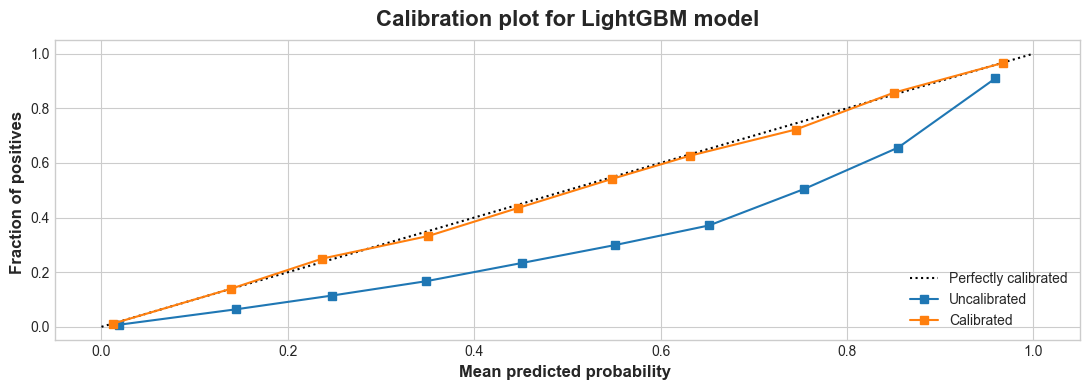

In [22]:
# calibration plot
uncalib_prob_true, uncalib_prob_pred = calibration_curve(y_true=y_test, y_prob=uncalibrated_predictions, n_bins=10)
calib_prob_true, calib_prob_pred = calibration_curve(y_true=y_test, y_prob=calibrated_predictions, n_bins=10)

_, ax = plt.subplots(1,1)
CalibrationDisplay(uncalib_prob_true, uncalib_prob_pred, uncalibrated_predictions, estimator_name='Uncalibrated').plot(ax=ax)
CalibrationDisplay(calib_prob_true, calib_prob_pred, calibrated_predictions, estimator_name='Calibrated').plot(ax=ax)
plt.title("Calibration plot for LightGBM model")

# save plot
plt.tight_layout()